## NLP Random Forest - Data Science Portfolio - Maximilian Koch

**Dataset**: US News headlines<br>
**Target variable**: news category<br>
**Features**: time, content<br>
**Techniques applied**: NLP Preprocessing, TF-IDF, Random Forest, hyperparameter optimisation<br>


Kaggle (https://www.kaggle.com/datasets/rmisra/news-category-dataset/data)

References:
1. Misra, Rishabh. "News Category Dataset." arXiv preprint arXiv:2209.11429 (2022).
2. Misra, Rishabh and Jigyasa Grover. "Sculpting Data for ML: The first act of Machine Learning." ISBN 9798585463570 (2021).


### Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_json('/content/drive/MyDrive/Maximilian Koch - News Dataset.json', lines=True)

Using a random forest classifier, I will predict the news category based of a short description that is provided to each article.
For simplicity reasons, I am only using 4 categories (out of the over 30 ones in the dataset).

In [ ]:
df = df[df['short_description'] != ""]
df = df[df['category'].isin(['POLITICS', 'ENTERTAINMENT', 'TRAVEL', 'SPORTS'])]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from scipy.sparse import csr_matrix

Taking some of the preprocessing from the previous notebook.

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Phrases
from gensim.models.phrases import Phraser
!pip install contractions
import contractions

import re
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

replacements = {
    'U.S.': 'usa', 'US': 'usa','Sen.': 'senator',
    'Rep.' : 'republican', 'Dem.' : 'democrat',
    'coronavirus' : 'covid19'
}

def expand_contractions(text):
    for old, new in replacements.items():
        text = text.replace(old, new) #manual fix
    return contractions.fix(text)

def clean_text(text):
    text = re.sub(r"[^\w\s']", '', text)  # Remove unwanted characters
    text = re.sub(r"'s\b", '', text)  # Remove 's genitives
    return text.lower()

def tokenize(text):
    return word_tokenize(text)

def stop_word_removal(tokens):
    stop_words = set(stopwords.words('english')).union({"'"})
    return [word for word in tokens if word.lower() not in stop_words]


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
#Taken and shortened from the workshop notebook!
import math
from collections import Counter

def compute_tf(documents):
    tf_documents = []
    for document in documents:
        tf_documents.append(Counter(document))
    return tf_documents

def compute_idf(tf_documents):
    df = Counter()
    for tf in tf_documents:
        for term in tf.keys():
            df[term] += 1
    idf = {}
    total_documents = len(tf_documents)
    for term, count in df.items():
        idf[term] = math.log(total_documents / float(count))
    return idf

def compute_tf_idf_manual(documents):
    tf_documents = compute_tf(documents)
    idf = compute_idf(tf_documents)
    tf_idf_documents = []
    for tf in tf_documents:
        tf_idf = {}
        for term, frequency in tf.items():
            tf_idf[term] = frequency * idf[term]
        tf_idf_documents.append(tf_idf)
    return tf_idf_documents


In [ ]:
df['tokens'] = df['short_description'].apply(expand_contractions).apply(clean_text).apply(tokenize).apply(stop_word_removal)

In [ ]:
tf_idf_documents = compute_tf_idf_manual(documents=df['tokens'])
df['tfidf'] = tf_idf_documents

### Random Forest Optimisation

In [ ]:
# Install and import necessary libraries
!pip install optuna
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import vstack
import numpy as np

vectorizer = DictVectorizer(sparse=True)
X = vectorizer.fit_transform(tf_idf_documents)

le = LabelEncoder()
y = le.fit_transform(df['category'])

#60, 20, 20 train/test/validation split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp)

best_model = 0

def objective(trial):
    global best_model

    n_estimators = trial.suggest_int("n_estimators", 50, 250)
    max_depth = trial.suggest_int("max_depth", 10, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    model = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,
        min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf,
        max_features=max_features,n_jobs=-1,)
    
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    #f1 macro score makes most sense to maximize since there is a class imbalance
    #and the model should predict well across classes and false positive/false negatives are equally bad here.
    f1 = f1_score(y_val, y_pred, average='macro')

    #update best model
    if trial.number == 0:
        best_model = model
    elif f1 > trial.study.best_value:
        best_model = model
    return f1

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Best hyperparameters:", study.best_params)

#combined training and validation sets for final training
X_train_full = vstack([X_train, X_val])
y_train_full = np.concatenate([y_train, y_val])

best_params = study.best_params
final_model = RandomForestClassifier(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    min_samples_leaf=best_params["min_samples_leaf"],
    max_features=best_params["max_features"],
    n_jobs=-1,)
final_model.fit(X_train_full, y_train_full)

y_test_pred = final_model.predict(X_test)
test_f1 = f1_score(y_test, y_test_pred, average='macro')
print("Test F1 Score:", test_f1)

print("Classification Report on Test Set:")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))


[I 2024-12-04 20:35:35,482] A new study created in memory with name: no-name-97c11176-ccfb-473a-a7d7-66f38969c240
[I 2024-12-04 20:36:36,252] Trial 0 finished with value: 0.3777473651710677 and parameters: {'n_estimators': 187, 'max_depth': 28, 'min_samples_split': 11, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 0 with value: 0.3777473651710677.
[I 2024-12-04 20:36:36,889] Trial 1 finished with value: 0.17349449138945341 and parameters: {'n_estimators': 168, 'max_depth': 26, 'min_samples_split': 19, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 0 with value: 0.3777473651710677.
[I 2024-12-04 20:36:37,479] Trial 2 finished with value: 0.17349449138945341 and parameters: {'n_estimators': 53, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.3777473651710677.
[I 2024-12-04 20:37:11,042] Trial 3 finished with value: 0.33398420762625786 and parameters: {'n_estimators': 150, 'max_depth': 14

Best hyperparameters: {'n_estimators': 224, 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': None}
Test F1 Score: 0.4105
Classification Report on Test Set:
               precision    recall  f1-score   support

ENTERTAINMENT       0.83      0.21      0.33      2955
     POLITICS       0.59      0.98      0.74      6488
       SPORTS       0.70      0.09      0.16       883
       TRAVEL       0.84      0.28      0.42      1884

     accuracy                           0.62     12210
    macro avg       0.74      0.39      0.41     12210
 weighted avg       0.70      0.62      0.55     12210



There are very noticeable differences between the classes, with politics being predicted best and sports being predicted worst, which partly might be because of the large class imbalance.
Let's see where exactly the differences are using the confusion matrix and which words have the highest influence on the category.

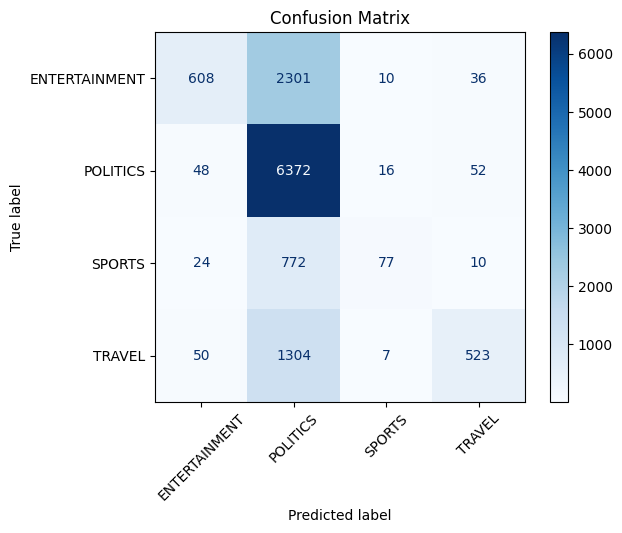

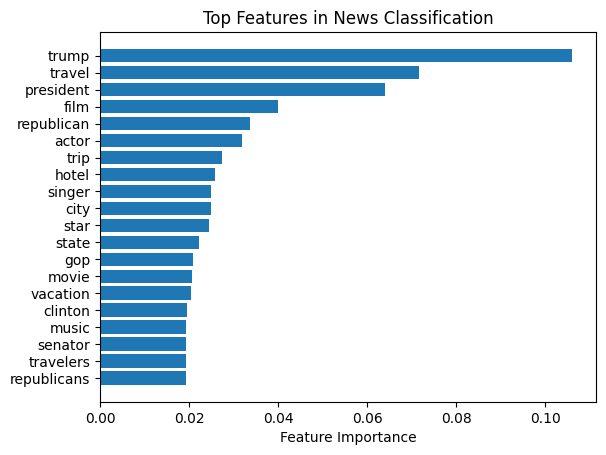

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

import numpy as np
feature_importances = final_model.feature_importances_
top_n = 20
top_features = np.argsort(feature_importances)[-top_n:]

plt.barh(range(top_n), feature_importances[top_features], align="center")
plt.yticks(range(top_n), [vectorizer.get_feature_names_out()[i] for i in top_features])
plt.xlabel("Feature Importance")
plt.title("Top Features in News Classification")
plt.show()



I find it quite remarkable that a substantial amount of headlines got predicted as entertainment although they are actually political. Also now we can see that the bad metrics of sports is because sport articles get misclassified as politics.

For visualization purposes, this is how the first tree of the forest decides on the category.

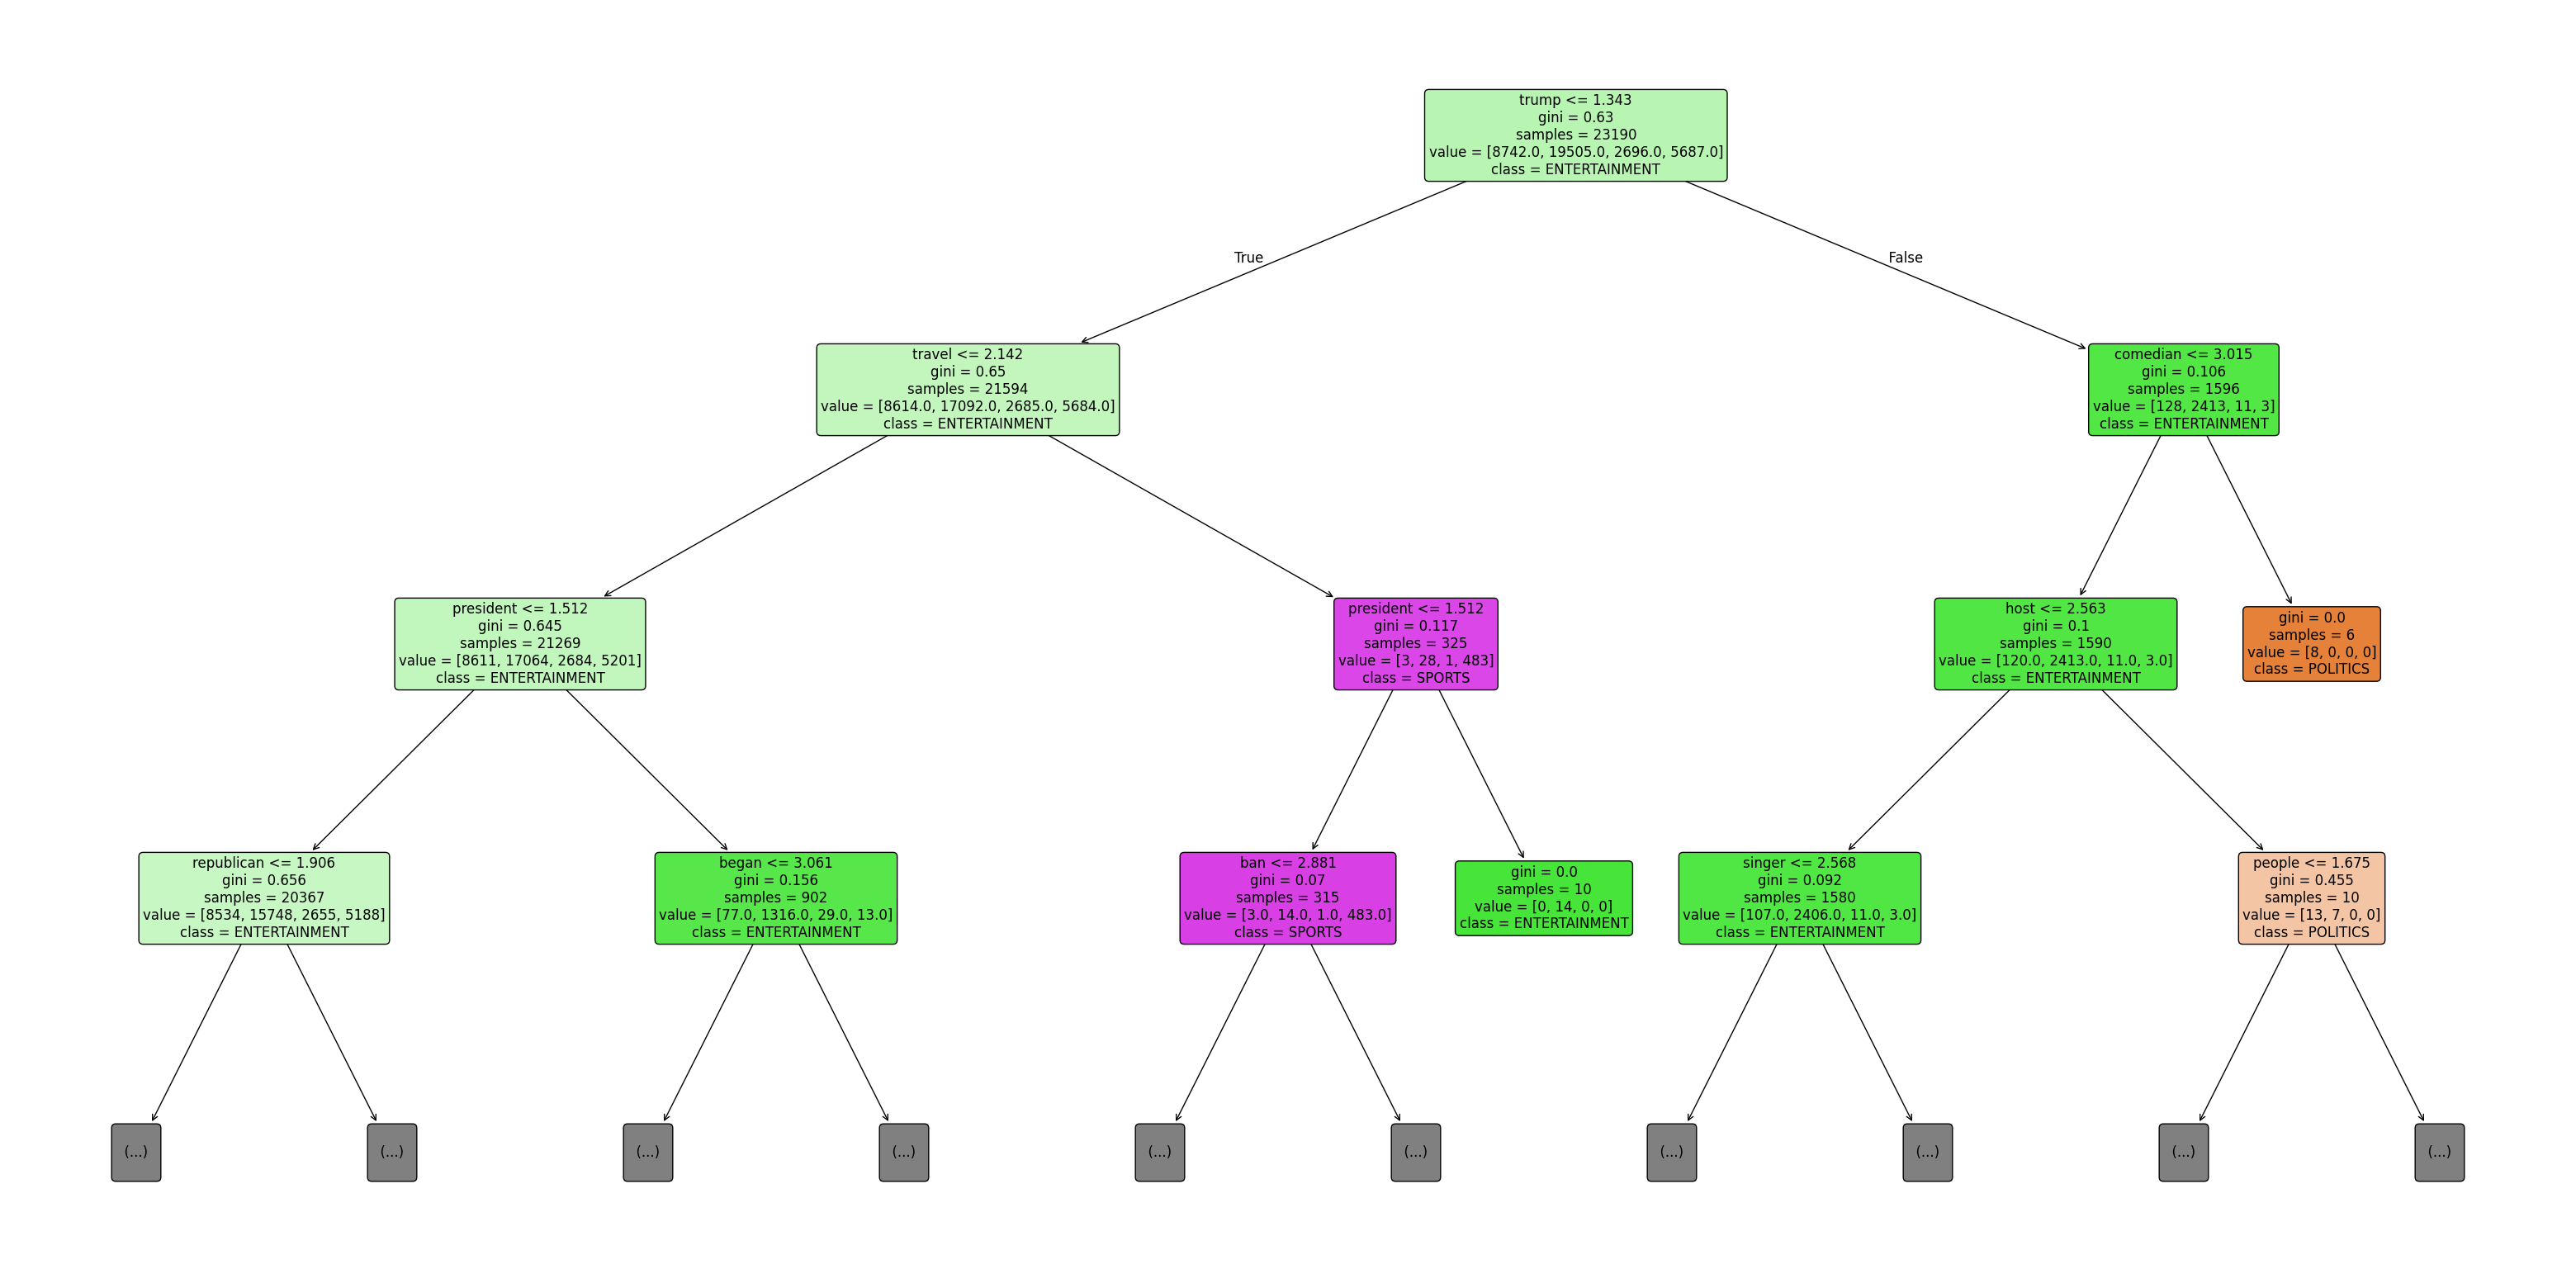

In [ ]:
from sklearn.tree import plot_tree

tree = best_model.estimators_[0]
plt.figure(figsize=(40, 20))
plot_tree(tree, feature_names=vectorizer.get_feature_names_out(), class_names=['POLITICS', 'ENTERTAINMENT', 'TRAVEL', 'SPORTS'],
    filled=True, rounded=True, fontsize=12, max_depth=3)
plt.show()